In [ ]:
import sys
import os

import matplotlib.pyplot as plt
import matplotlib_utils
from wandb_utils import *
from pandas_utils import *
import matplotlib
import numpy as np
from itertools import product
import pandas as pd

from matplotlib.gridspec import *

WANDB_ENTITY = "nzucchet"
WANDB_PROJECT = "online-bptt"

## Shallow models

In [ ]:
results = load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/uksrvrcj")

In [5]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
best_lrs = find_best_lr(df, groupby)
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.90,2.074513,0.292098
1,forward,0.99,1.597095,0.577760
2,forward_forward,0.90,0.857835,0.955679
3,forward_forward,0.99,0.820613,0.953954
4,normal,0.90,0.772239,0.970608
5,normal,0.99,0.744038,0.968717
6,spatial,0.90,0.857996,0.954054
7,spatial,0.99,0.826995,0.958367


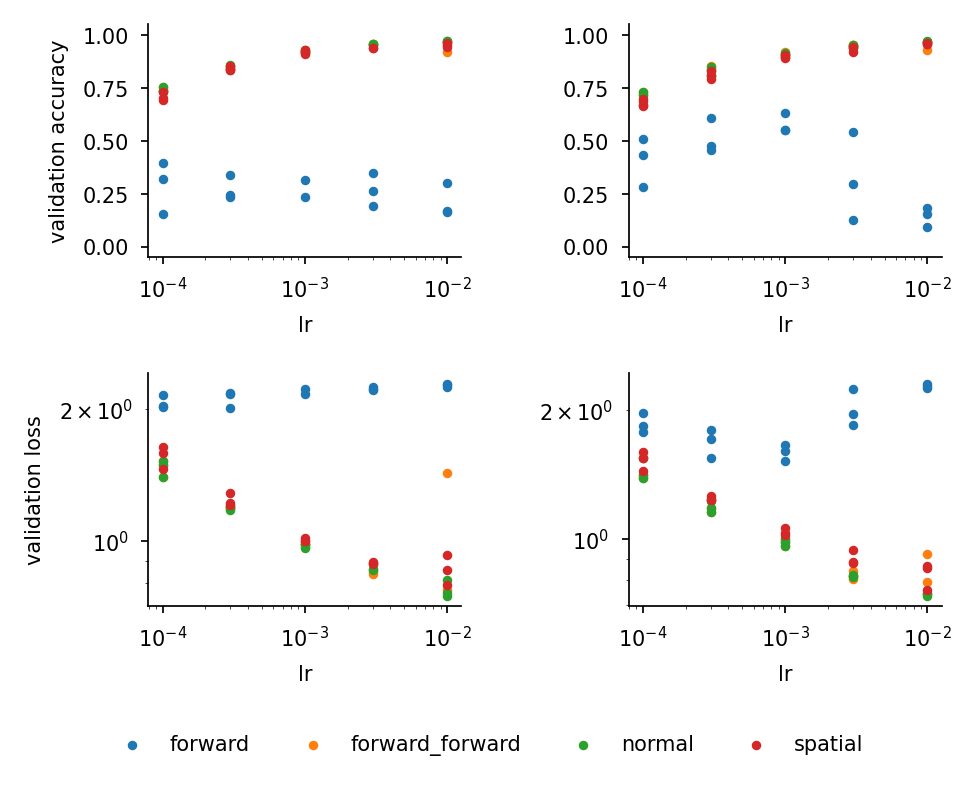

In [6]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")
    ax[1][i].set_yscale("log")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## Comparison, deep models (2 layers)

In [ ]:
results = load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/1x0swk5c")

In [8]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
best_lrs = find_best_lr(results, groupby)
df = select_last_step(results, groupby + [learning_rate])
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.90,2.291927,0.138071
1,forward,0.99,2.203892,0.219579
2,forward_forward,0.90,0.743206,0.971902
3,forward_forward,0.99,0.697199,0.977044
4,normal,0.90,0.681127,0.982617
5,normal,0.99,0.698681,0.979333
6,spatial,0.90,0.730706,0.965516
7,spatial,0.99,0.848546,0.913150


0
1


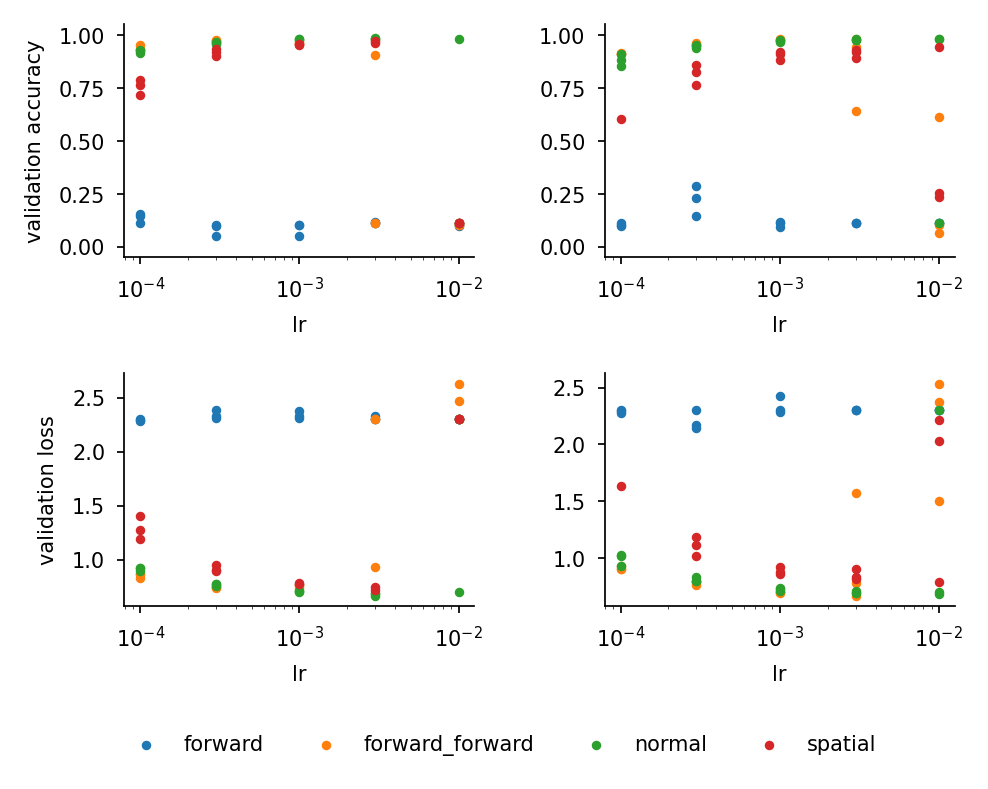

In [9]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    print(i)
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## Ablation number forward passes (4 layers)

In [ ]:
results = load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/184mlacs")

In [35]:
groupby = ["model.forward_simulation_passes"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
best_lrs = find_best_lr(df, groupby)
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.forward_simulation_passes,val/loss,val/acc
0,1,0.792094,0.942277
1,2,0.717856,0.969546
2,3,0.713879,0.971304
3,4,0.692173,0.978603
4,5,0.676488,0.980228


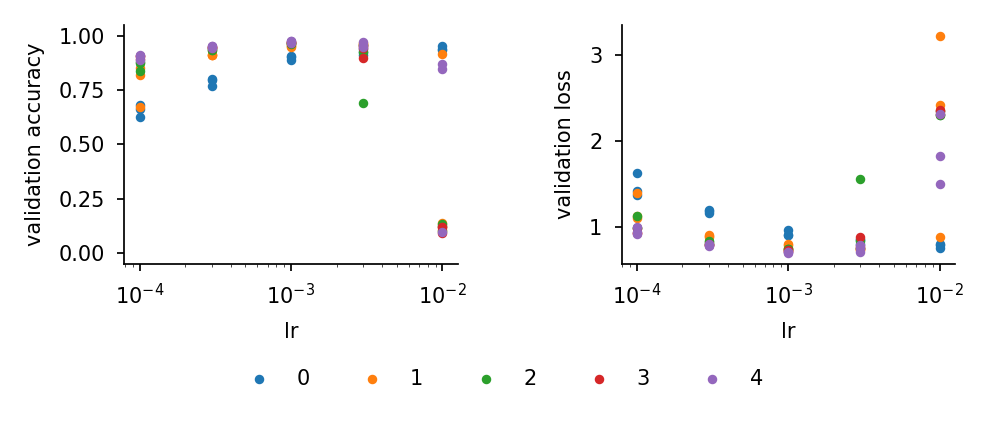

In [12]:
groupby = ["model.forward_simulation_passes"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(1, 2, figsize=(4, 1.6))
for i, passes in enumerate(df["model.forward_simulation_passes"].unique()):
    this_df = select(df, {"model.forward_simulation_passes": passes})
    ax[0].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=i)
    ax[1].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=i)
ax[0].set_xscale("log")
ax[0].set_xlabel("lr")
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xscale("log")
ax[1].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=5, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0].set_ylabel("validation accuracy")
ax[1].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## Varying recurrent learning rate (4 layers, 32 hiddens)

In [ ]:
results = load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/joskbima")

In [26]:
groupby = ["model.training_mode", "training.recurrent_lr_factor", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
best_lrs = find_best_lr(df, groupby)
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
final = best_results.groupby(groupby).mean().reset_index()
final.columns = ['training mode', 'rec lr factor', 'r_min', 'loss', 'acc']
final

,training mode,rec lr factor,r_min,loss,acc
0,forward_forward,0.25,0.90,0.690412,0.981937
1,forward_forward,0.25,0.99,0.672777,0.981854
2,forward_forward,0.50,0.90,0.699011,0.981423
3,forward_forward,0.50,0.99,0.683103,0.977243
4,forward_forward,1.00,0.90,0.745541,0.970193
5,forward_forward,1.00,0.99,0.697199,0.977044
6,normal,0.25,0.90,0.691402,0.982285
7,normal,0.25,0.99,0.688564,0.979996
8,normal,0.50,0.90,0.677875,0.982982
9,normal,0.50,0.99,0.686492,0.979532


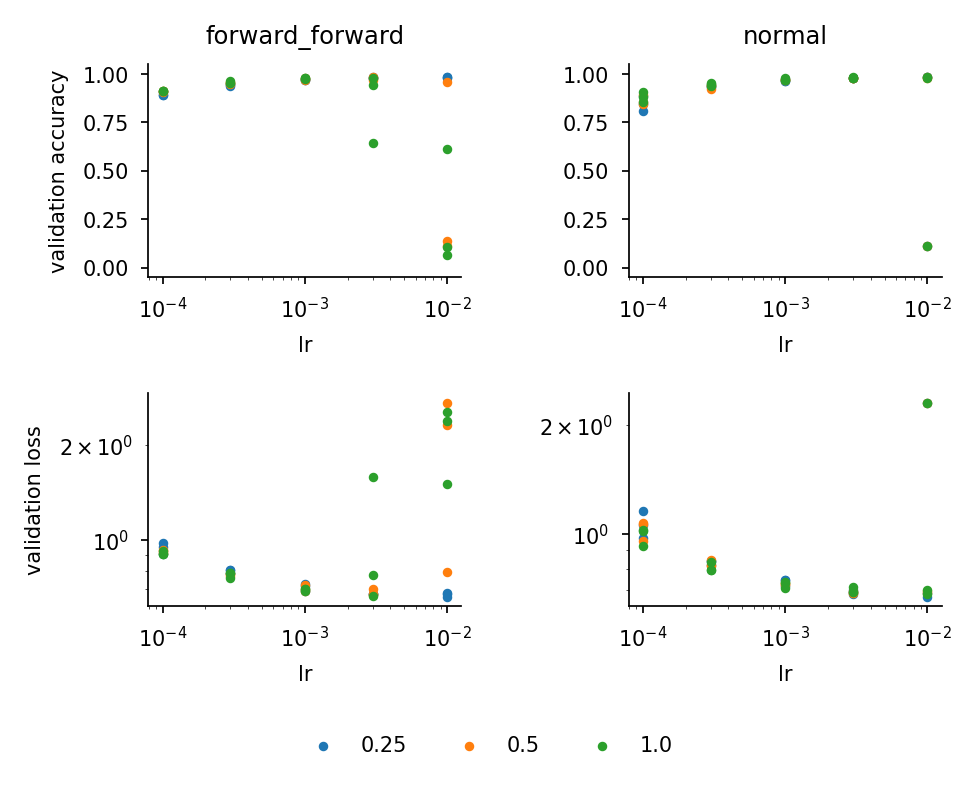

In [31]:
groupby = ["model.training_mode", "training.recurrent_lr_factor", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])
df = select(df, {"model.lru_r_min": 0.99})

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, training_mode in enumerate(df["model.training_mode"].unique()):
    for lrfac in df["training.recurrent_lr_factor"].unique():
        this_df = select(df, {"training.recurrent_lr_factor": lrfac, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=lrfac)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=lrfac)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")
    ax[1][i].set_yscale("log")
    ax[0][i].set_title(training_mode, size=7)

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)

## FUll MNIST, comparison

In [ ]:
results = pd.concat([
    load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/vcofbt5x"),
    load_sweep(f"{WANDB_ENTITY}/{WANDB_PROJECT}/ay6ll858"),
])

In [15]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
best_lrs = find_best_lr(results, groupby)
df = select_last_step(results, groupby + [learning_rate])
best_results = select_best_lr(df, groupby, best_lrs)[groupby + ["val/loss", "val/acc"]]
best_results.groupby(groupby).mean().reset_index()

,model.training_mode,model.lru_r_min,val/loss,val/acc
0,forward,0.990,2.125356,0.314457
1,forward,0.999,1.978657,0.361332
2,forward_forward,0.990,0.716111,0.968617
3,forward_forward,0.999,0.709317,0.965134
4,normal,0.990,0.649978,0.981058
5,normal,0.999,0.649314,0.982152
6,spatial,0.990,0.723215,0.960423
7,spatial,0.999,0.797820,0.925159


0
1


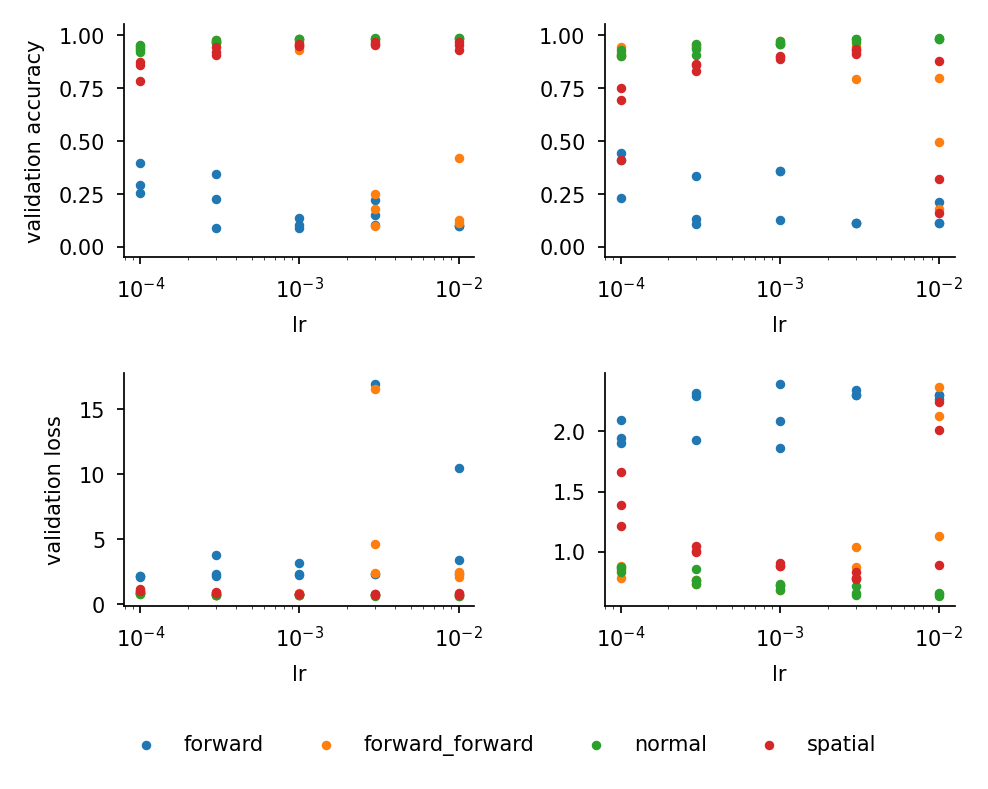

In [16]:
groupby = ["model.training_mode", "model.lru_r_min"]
learning_rate = "training.learning_rate"
df = select_last_step(results, groupby + [learning_rate])

fig, ax = plt.subplots(2, 2, figsize=(4, 3))
for i, r_min in enumerate(df["model.lru_r_min"].unique()):
    print(i)
    for training_mode in df["model.training_mode"].unique():
        this_df = select(df, {"model.lru_r_min": r_min, "model.training_mode": training_mode})
        ax[0][i].scatter(this_df[learning_rate], this_df["val/acc"], s=3, label=training_mode)
        ax[1][i].scatter(this_df[learning_rate], this_df["val/loss"], s=3, label=training_mode)
    ax[0][i].set_xscale("log")
    ax[0][i].set_xlabel("lr")
    ax[0][i].set_ylim(-0.05, 1.05)
    ax[1][i].set_xscale("log")
    ax[1][i].set_xlabel("lr")

# Build a single legend below both axes, centered
handles, labels = [], []
for a in ax[1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
seen = set()
unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        unique.append((h, l))
        seen.add(l)
if unique:
    handles, labels = zip(*unique)
    fig.legend(handles, labels, loc="lower center", ncol=4, fontsize=6, bbox_to_anchor=(0.5, -0.05), frameon=False)

ax[0][0].set_ylabel("validation accuracy")
ax[1][0].set_ylabel("validation loss")

# Tight layout with bottom margin for the legend
plt.tight_layout(rect=[0, 0.02, 1, 1], w_pad=2)